In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import logging
import itertools
import ast
#
import airavata_cerebrum.model.setup as cbm_setup
import airavata_cerebrum.view.tree as cbm_tree
import airavata_cerebrum.model.recipe as cbm_recipe
import airavata_cerebrum.util.io as cbm_io
import wbn_sleep.model as wbn_model

# Setup the Model Recipe and the Recipe Templates

Model recipe is defined by a recipe file named recipe.json and template file name recipe_template.json. 
The files are placed in the recipe directory, canonically under the base directory of the model.

## recipe.json

recipe.json contains two sections: (1) data2model_map and (2) source_data. 
data2model_map maps between how the different parts of the model map to the source data. 
The source_data describes how the source databases are connected and different operations such as filters are applied to the data available from the specific database.


**Currently this is not used in the construction. In the future, this may be added to the consturction**

In [3]:
import pathlib
model_base_dir = "./"
model_name = "wbn_sleep"
custom_mod_file = "./wbn_sleep/recipe/custom_mod.json"
recipe_dir = "./wbn_sleep/recipe/"
recipe_files={"recipe": ["recipe.json"], "templates": ["recipe_template.json"] }
recipe_main_file = pathlib.Path(recipe_dir, recipe_files["recipe"][0])

In [4]:
import IPython.display
import json
with open(recipe_main_file) as ifx:
    config_dict = json.load(ifx)
IPython.display.JSON(config_dict)

<IPython.core.display.JSON object>

In [5]:
mdr_setup = cbm_setup.init_model_setup(
    name=model_name,
    model_base_dir=model_base_dir,
    recipe_files=recipe_files,
    recipe_dir=recipe_dir,
)

Loading View Templates



## Whole brain Network

The network is defined byt the "custom_mod.json". It includes:
- Details required for network construction that are either not available in the linked databases or over-ride specific information.
- Utilities to visualize these modifications in Jupyter Notebook.

For the Whole brain network, it includes
1. Neuron Types and Dimensions.
2. Connection Types and Parameters.
3. Input Data files. 

Using the templates we can view the user custom modifications with Jupter notebook widgets. Running the next cell should produce a visualization in the image below:

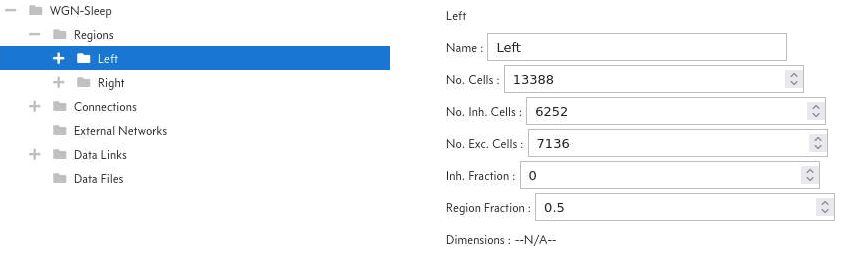

In [6]:
import IPython.display
import json
with open(custom_mod_file) as ifx:
    custom_mod_dict = json.load(ifx)
IPython.display.JSON(custom_mod_dict)

<IPython.core.display.JSON object>

In [7]:
custom_mods = cbm_recipe.netstruct_from_file(custom_mod_file)
cmod_view = cbm_tree.NetworkTreeView(custom_mods, left_width="55%")
cmod_view.build()
cmod_view.layout

TwoByTwoLayout(children=(Tree(layout=Layout(grid_area='top-left', width='55%'), multiple_selection=False, node…

# Genrate Config Files from UI

The following python code generates the configuration files for network generation based on the inputs given in the UI.

 
#### Input/Config Files for Network Generation

The following two input config files are required. Examples are provided in the config/ directory of `https://github.com/srirampc/wbn_sleep`.
1. mriNetworkNew.json : Defines the network neuron types and connections.
2. data_config.json : Defines the paths to data files, whose format is as below; Make sure the data files pointed in the files are available 
.

```json
     {
         "left_subnet" : "./data/Map_642_To_10242_30-Aug-2017_LH.txt",
         "right_subnet": "./data/Map_642_To_10242_30-Aug-2017_RH.txt",
         "left_right_map": "./data/Map_LH_RH_10242_30-Aug-2017.txt",
         "left_right_map_small": "./data/Map_LH_RH_642_30-Aug-2017.txt",
         "dist3d_probability": "./data/dist_inMeters_prob_LH_onesOnDiag.txt",
         "weight_factor": "./data/weights_LH.txt",
         "weight_factor_inpy": "./data/weights_INPY_both_hemi.txt",
         "thalamus_cortex_distance": "./data/thalCort_dist_inMeters_LH.txt",
         "intra_thalamus_distance":  "./data/dist_TC_LH_zeroDiag.txt"
     }
```

### Generate configuration from tree structure

Following python code generates from the tree structure

In [8]:
def get_node_by_key(parent_node, node_key):
    if parent_node.node_key == node_key:
        return parent_node
    for child_node in parent_node.nodes:
        found_node = get_node_by_key(child_node, node_key)
        if found_node:
            return found_node
    return None

## 
root_node = cmod_view.tree.nodes[0]
location_node = get_node_by_key(root_node, "net.locations")
connections_node = get_node_by_key(root_node, "net.connections")
data_links_node = get_node_by_key(root_node, "net.data_links")
#
left_loc_node = get_node_by_key(location_node, "Left")
right_loc_node = get_node_by_key(location_node, "Right")

In [9]:
#
def conn_config(conn_node):
    return ({
        "from": ast.literal_eval(conn_node.pre)[1],
        "to": ast.literal_eval(conn_node.post)[1],
        "type": cmx_node.property_map["name"],
        "property_map": cmx_node.property_map
    } for cmx_node in conn_node.nodes)

def region_config(loc_node):
    return ({
        "name": node.name, 
        "dims": node.dims
    } for node in loc_node.nodes)


network_cfg = {
    "ratio_x": 1,
    "ratio_y": 1,
    "types": list(
        itertools.chain(region_config(left_loc_node),
                        region_config(right_loc_node))
    ),
    "connections":list(
        itertools.chain(
            *(conn_config(cx_node) for cx_node in connections_node.nodes)
        )
    )
}
data_files_config = {node.name:node.path for node in data_links_node.nodes}

# 
cbm_io.dump_json(network_cfg, "./wbn_sleep/network_config.json", indent=4)
cbm_io.dump_json(data_files_config, "./wbn_sleep/data_config.json", indent=4)


# Generate Networks

Before generating the network make sure that 

1. Data files are placed in the data directory, and
2. generate_network is in the appropriate path.


`generate_network` is run as follows

In [10]:
!$HOME/data2/wbn_sleep/build/generate_network -h 

Usage: /storage/home/hhive1/schockalingam6/data2/wbn_sleep/build/generate_network [OPTIONS]

Options:
  -h,--help                   Print this help message and exit
  -c,--config TEXT:FILE REQUIRED
                              Path to the Input Config File
  -s,--connect_summary TEXT [connSummaryFileexample.txt] 
                              Path to Connection Summary File
  -d,--data-config TEXT:FILE  Path to Data Config File
  -o,--output-file TEXT [network_output.txt]  REQUIRED
                              Path to Output File
  -p,--parallel               Flag if Parallel Run
  --parallel-read             Flag if Parallel Read of input file
  --parallel-build            Flag if Parallel Build 


In [11]:
!$HOME/data2/wbn_sleep/build/generate_network -c ./wbn_sleep/network_config.json -d ./wbn_sleep/data_config.json -o ./wbn_sleep/wbn_network.txt -s ./wbn_sleep/connect_summary.txt


 ┌──────────────────────────────────────────────────────────────┐
 │ Network Config. File       : ./wbn_sleep/network_config.json │
 │ Output File                : ./wbn_sleep/wbn_network.txt     │
 │ Connection Summary File    : ./wbn_sleep/connect_summary.txt │
 │ Data Config. File          : ./wbn_sleep/data_config.json    │
 │ Parallel Constr.           : false                           │
 │ Parallel Weights Reading.  : false                           │
 │ Parallel Network Build.    : false                           │
 └──────────────────────────────────────────────────────────────┘
 ┌───────────────────────────────────────────────────────────────────────────────────┐
 │ left_subnet               : ./wbn_sleep/data/Map_642_To_10242_30-Aug-2017_LH.txt  │
 │ right_subnet              : ./wbn_sleep/data/Map_642_To_10242_30-Aug-2017_RH.txt  │
 │ left_right_map            : ./wbn_sleep/data/Map_LH_RH_10242_30-Aug-2017.txt      │
 │ left_right_map_small      : ./wbn_sleep/data/Map_LH_RH_

# Generate Networks in Parallel

Parallel implementation consists of two parts:

1. Reading the input data file (specifically the weights files).
2. Building the network (i.e., construction of the edge list).

The weights input file is read in parallel if `--parallel-read` flag is set.
The edge list construction is done in parallel if `--parallel-build` flag is set.
If the `-p` or `--parallel` flag is set, both the parallellizaton is run.
As of this now, parallel network building always produces a random network. 
If the network construction needed to be sequential, please use `--parallel-read`
flag.


*Shown below is a run with 24 cores, which took 4 minutes compared to 24 minutes it took for the sequential run.*


In [12]:
!$HOME/data2/wbn_sleep/build/generate_network -p -c ./wbn_sleep/network_config.json -d ./wbn_sleep/data_config.json -o ./wbn_sleep/wbn_network_par.txt -s ./wbn_sleep/connect_summary_par.txt


 ┌──────────────────────────────────────────────────────────────────┐
 │ Network Config. File       : ./wbn_sleep/network_config.json     │
 │ Output File                : ./wbn_sleep/wbn_network_par.txt     │
 │ Connection Summary File    : ./wbn_sleep/connect_summary_par.txt │
 │ Data Config. File          : ./wbn_sleep/data_config.json        │
 │ Parallel Constr.           : true                                │
 │ Parallel Weights Reading.  : true                                │
 │ Parallel Network Build.    : true                                │
 └──────────────────────────────────────────────────────────────────┘
 ┌───────────────────────────────────────────────────────────────────────────────────┐
 │ left_subnet               : ./wbn_sleep/data/Map_642_To_10242_30-Aug-2017_LH.txt  │
 │ right_subnet              : ./wbn_sleep/data/Map_642_To_10242_30-Aug-2017_RH.txt  │
 │ left_right_map            : ./wbn_sleep/data/Map_LH_RH_10242_30-Aug-2017.txt      │
 │ left_right_map_smal

# Network Generation with model Recipe

**TODO: future work**

In [14]:
model_recipe = cbm_recipe.ModelRecipe(
    recipe_setup=mdr_setup,
    region_mapper=wbn_model.WGNRegionMapper,                                                                                                                                                                                                         
    neuron_mapper=wbn_model.WGNNeuronMapper,                                                                                                                                                                                                         
    connection_mapper=wbn_model.WGNConnectionMapper,                                                                                                                                                                                                     
    network_builder=wbn_model.WGNNetworkBuilder,                                                                                                                                                                                                   
    custom_mod=custom_mods,                                                                                                                                                                                                               
    save_flag=True,
)                                                                                                                                                                                                                                   
# logging.basicConfig(level=logging.INFO)

# Network Simulation 

**TODO: future work**